In [1]:
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pickle

In [2]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff  

class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [34]:
psd = xr.load_dataset('../../data/Processed/psd_coare3p0_wpapa.nc')
psd['weight'] = psd['weight']*psd.sizes['time']

from mlflux.datafunc import data_split_psd, data_split_psd_rand
from mlflux.ann import RealFluxDataset

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
# split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
# split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
# split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
# split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
# split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
# split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
# split_ensem = [split1, split2, split3, split4, split5, split6]

# New split according to weights
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]] # metz
split2 = [[77, 69, 83, 87, 68], [67, 72, 73, 78, 71], [67, 72, 73, 78, 71]] # calwater, hiwings, capricorn, neaqs, gasex
split3 = [[77, 67, 72, 73, 78, 71], [68, 83, 69, 87], [68, 83, 69, 87]] # dynamo, stratus, epic, whots
split_ensem = [split1, split2, split3]

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [50]:
psd

<xarray.Dataset>
Dimensions:  (time: 10079)
Coordinates:
  * time     (time) datetime64[ns] 1996-12-22T19:00:00.288000 ... 2016-04-13T...
Data variables: (12/21)
    taucx    (time) float64 0.1895 0.6395 0.3934 ... 0.07723 0.07373 0.08168
    taucy    (time) float64 0.0333 0.1182 -0.023 ... -0.06492 -0.02255 -0.0589
    hsc      (time) float64 -29.54 -100.4 -60.81 -142.7 ... -5.808 1.075 -13.14
    hlc      (time) float64 -99.11 -180.2 -153.9 -218.3 ... -39.32 -43.95 -109.2
    U        (time) float64 12.14 16.7 16.75 17.0 ... 9.779 8.903 8.239 8.543
    tsea     (time) float64 7.569 11.82 11.86 11.91 ... 11.43 10.9 11.38 12.66
    ...       ...
    wdir     (time) float64 75.04 68.66 65.81 66.5 ... 284.7 282.9 270.4 283.4
    hlb      (time) float64 -129.8 -175.0 -181.8 -194.0 ... -17.21 -34.88 -27.76
    hsb      (time) float64 -42.07 -81.74 -73.27 -87.61 ... -2.911 3.171 -10.27
    taubx    (time) float64 0.2515 0.5628 0.5641 ... 0.1085 0.08727 0.1017
    tauby    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    weight   (time) float64 0.006158 4.959 13.3 10.83 ... 10.03 0.4509 10.11

In [45]:
''' Testing '''
def mse_r2_weighted(ypred, ytruth, weight):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, weights=weight, axis=0)
    ytruth_mean = np.average(ytruth, weights=weight, axis=0)
    ytruth_var = np.average((ytruth-ytruth_mean)**2, weights=weight, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, weights=weight, axis=0)/ytruth_var
    return (mse, r2)

def evaluate_over_splits (model, keys, RAND=True, WEIGHT=True):
    split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]] # metz
    split2 = [[77, 69, 83, 87, 68], [67, 72, 73, 78, 71], [67, 72, 73, 78, 71]] # calwater, hiwings, capricorn, neaqs, gasex
    split3 = [[77, 67, 72, 73, 78, 71], [68, 83, 69, 87], [68, 83, 69, 87]] # dynamo, stratus, epic, whots
    split_ensem = [split1, split2, split3]
    nn_r2_splits = []; bulk_r2_splits = []
    for i in range(3):
        if RAND:
            training_ds, validating_ds, testing_ds = data_split_psd_rand(psd, seed=1+i, ratio=0.5)
        else:
            training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[i], PLOT=False, XVIS='samples', VERBOSE=False)
        vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

        Ypred_mean = model.pred_mean(vd.X)
        if WEIGHT:
            ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W)
            bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        else:
            ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
            bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)            
        nn_r2_splits.append(ann_r2); bulk_r2_splits.append(bulk_r2)
        # print('NN (weighted) r2 %.4f, bulk (weighted) r2 %.4f' %(ann_r2, bulk_r2))

        # Ypred_var = self.pred_var(X)
        # residual_norm = (Ytruth - Ypred_mean) / Ypred_var**0.5
        # wd = []
        # for yi in range(residual_norm.shape[-1]):
        #     r = norm.rvs(size=1000000)  # Pick a big numble of samples from normal distribution  
        #     l1 = wasserstein_distance(residual_norm[:,yi].detach(),r)
        #     wd.append(l1)  
        # self.scores = {'mse':mse.detach(), 'r2':r2.detach(), 'wd':np.array(wd)}  
        
    return (np.array(nn_r2_splits).squeeze(), np.array(bulk_r2_splits).squeeze())

### R2 

In [5]:
model_dir = '/home/jw8736/mlflux/saved_model/one_output_anns/'
model_names = ['Flux41_momentum_3layers_weighted_rand%g.p', 
               'Flux41_sensible_3layers_weighted_rand%g.p', 
               'Flux41_latent_3layers_weighted_rand%g.p']

/state/partition1/job-51952572/ipykernel_4015843/1824322918.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1824322918.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1824322918.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weigh

Weighted ann r2 0.802637 bulk r2 0.790388
Unweighted ann r2 0.823236 bulk r2 0.825892
Weighted ann r2 0.80058 bulk r2 0.790388
Unweighted ann r2 0.819472 bulk r2 0.825892
Weighted ann r2 0.786787 bulk r2 0.790388
Unweighted ann r2 0.804378 bulk r2 0.825892
Weighted ann r2 0.805029 bulk r2 0.790388
Unweighted ann r2 0.8255 bulk r2 0.825892


/state/partition1/job-51952572/ipykernel_4015843/1824322918.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1824322918.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1824322918.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weigh

Text(0.5, 1.0, 'Random splitting (50%)')

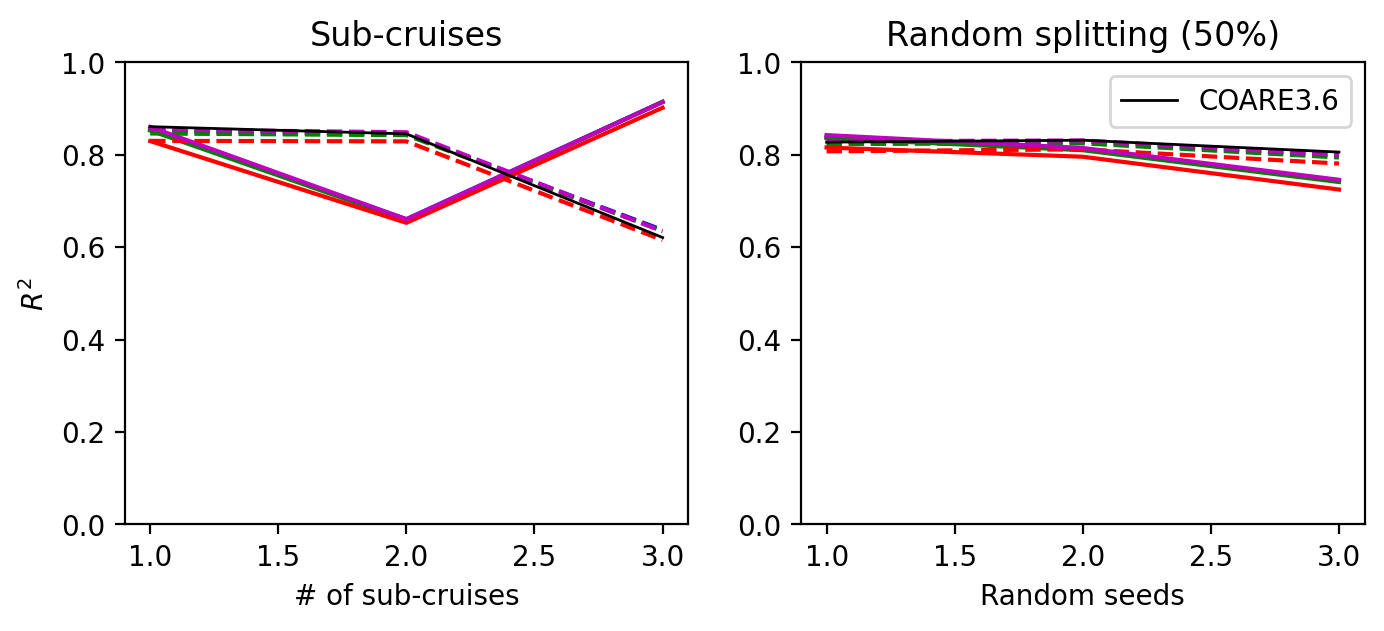

In [48]:
colors = ['b','g','r','m']
x = [1,2,3]

fig,axes = plt.subplots(1,2,figsize=[8,3],dpi=200)

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
for i, seed in enumerate((7,8,9,10)):
    filename = model_dir + model_names[0] %seed
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)       
        nn_taux_r2_splits, bulk_taux_r2_splits_psd = evaluate_over_splits(model, keys, RAND=False, WEIGHT=True)
        axes[0].plot(x, nn_taux_r2_splits, c=colors[i])    
        nn_taux_r2_splits, bulk_taux_r2_splits_psd = evaluate_over_splits(model, keys, RAND=False, WEIGHT=False)
        axes[0].plot(x, nn_taux_r2_splits, c=colors[i], ls='--')    
        
        nn_taux_r2_splits, bulk_taux_r2_splits_rand = evaluate_over_splits(model, keys, RAND=True, WEIGHT=True)
        axes[1].plot(x, nn_taux_r2_splits, c=colors[i])
        nn_taux_r2_splits, bulk_taux_r2_splits_rand = evaluate_over_splits(model, keys, RAND=True, WEIGHT=False)
        axes[1].plot(x, nn_taux_r2_splits, c=colors[i], ls='--')

                
        # On the whole dataset
        vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        Ypred_mean = model.pred_mean(vd.X)
        ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
        ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
        bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
        print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))

axes[0].plot(x, bulk_taux_r2_splits_psd, '-', c='k', label='COARE3.6', lw=1)
axes[0].set_xlabel('# of sub-cruises')
axes[1].plot(x, bulk_taux_r2_splits_rand, '-', c='k', label='COARE3.6', lw=1)
axes[1].set_xlabel('Random seeds')
        
axes[0].set_ylim([0.,1]); 
axes[0].set_ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend()
axes[0].set_title(r'Sub-cruises')
axes[1].set_title(r'Random splitting (50%)')

/state/partition1/job-51952572/ipykernel_4015843/1376226284.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1376226284.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1376226284.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weigh

Weighted ann r2 0.324113 bulk r2 0.352386
Unweighted ann r2 0.448852 bulk r2 0.540937
Weighted ann r2 0.316975 bulk r2 0.352386
Unweighted ann r2 0.416883 bulk r2 0.540937
Weighted ann r2 0.322156 bulk r2 0.352386
Unweighted ann r2 0.448723 bulk r2 0.540937
Weighted ann r2 0.318178 bulk r2 0.352386
Unweighted ann r2 0.413878 bulk r2 0.540937


/state/partition1/job-51952572/ipykernel_4015843/1376226284.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1376226284.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/1376226284.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weigh

Text(0.5, 1.0, 'Random splitting (50%)')

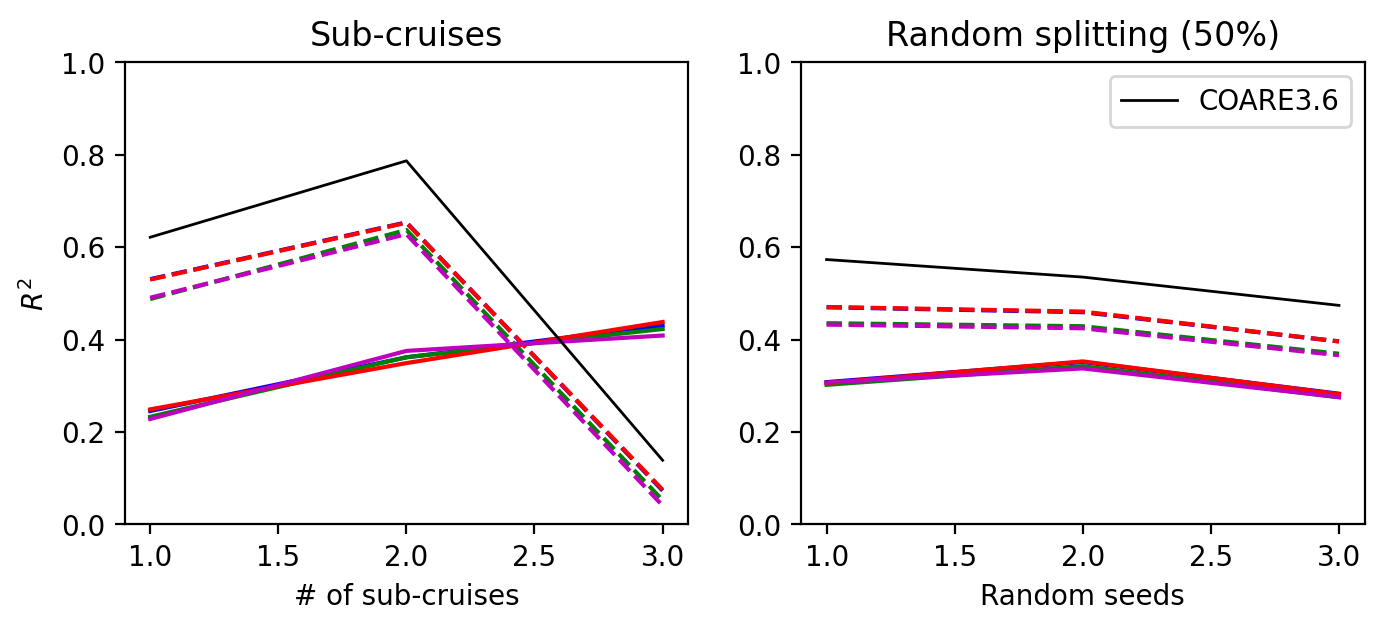

In [49]:
colors = ['b','g','r','m']
x = [1,2,3]

fig,axes = plt.subplots(1,2,figsize=[8,3],dpi=200)

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
for i, seed in enumerate((7,8,9,10)):
    filename = model_dir + model_names[1] %seed
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)       
        nn_taux_r2_splits, bulk_taux_r2_splits_psd = evaluate_over_splits(model, keys, RAND=False, WEIGHT=True)
        axes[0].plot(x, nn_taux_r2_splits, c=colors[i])    
        nn_taux_r2_splits, bulk_taux_r2_splits_psd = evaluate_over_splits(model, keys, RAND=False, WEIGHT=False)
        axes[0].plot(x, nn_taux_r2_splits, c=colors[i], ls='--')    
        
        nn_taux_r2_splits, bulk_taux_r2_splits_rand = evaluate_over_splits(model, keys, RAND=True, WEIGHT=True)
        axes[1].plot(x, nn_taux_r2_splits, c=colors[i])
        nn_taux_r2_splits, bulk_taux_r2_splits_rand = evaluate_over_splits(model, keys, RAND=True, WEIGHT=False)
        axes[1].plot(x, nn_taux_r2_splits, c=colors[i], ls='--')
                
        # On the whole dataset
        vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        Ypred_mean = model.pred_mean(vd.X)
        ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
        ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
        bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
        print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))

axes[0].plot(x, bulk_taux_r2_splits_psd, '-', c='k', label='COARE3.6', lw=1)
axes[0].set_xlabel('# of sub-cruises')
axes[1].plot(x, bulk_taux_r2_splits_rand, '-', c='k', label='COARE3.6', lw=1)
axes[1].set_xlabel('Random seeds')
        
axes[0].set_ylim([0.,1]); 
axes[0].set_ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend()
axes[0].set_title(r'Sub-cruises')
axes[1].set_title(r'Random splitting (50%)')

/state/partition1/job-51952572/ipykernel_4015843/783942551.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/783942551.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/783942551.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted

Weighted ann r2 0.52618 bulk r2 0.397419
Unweighted ann r2 0.502489 bulk r2 0.602281
Weighted ann r2 0.52651 bulk r2 0.397419
Unweighted ann r2 0.407975 bulk r2 0.602281
Weighted ann r2 0.524129 bulk r2 0.397419
Unweighted ann r2 0.445688 bulk r2 0.602281
Weighted ann r2 0.518595 bulk r2 0.397419
Unweighted ann r2 0.474043 bulk r2 0.602281


/state/partition1/job-51952572/ipykernel_4015843/783942551.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
/state/partition1/job-51952572/ipykernel_4015843/783942551.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))


Text(0.5, 1.0, 'Random splitting (50%)')

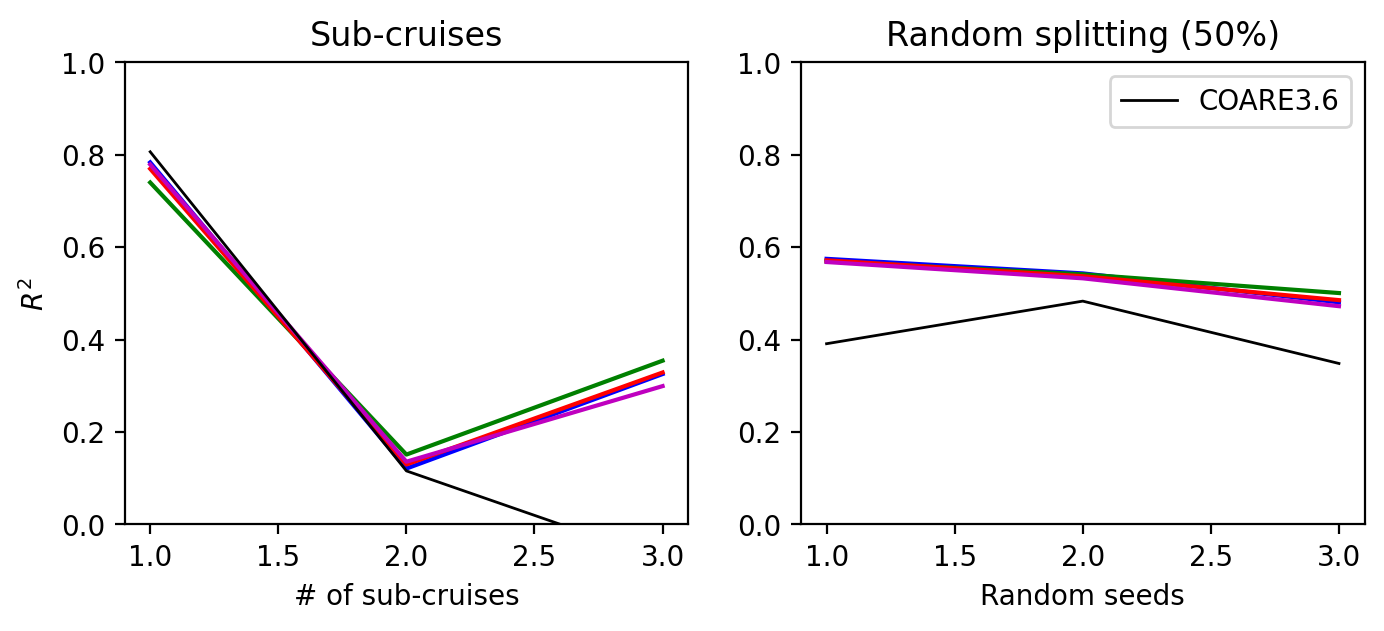

In [43]:
colors = ['b','g','r','m']
x = [1,2,3]

fig,axes = plt.subplots(1,2,figsize=[8,3],dpi=200)

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
for i, seed in enumerate((7,8,9,10)):
    filename = model_dir + model_names[2] %seed
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)       
        model.nn_taux_r2_splits, model.bulk_taux_r2_splits_psd = evaluate_over_splits(model, keys, RAND=False)
        axes[0].plot(x, model.nn_taux_r2_splits, c=colors[i])    
        
        model.nn_taux_r2_splits, model.bulk_taux_r2_splits_rand = evaluate_over_splits(model, keys, RAND=True)
        axes[1].plot(x, model.nn_taux_r2_splits, c=colors[i])

                
        # On the whole dataset
        vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])
        Ypred_mean = model.pred_mean(vd.X)
        ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W)
        print('Weighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))
        ann_mse, ann_r2 = mse_r2_weighted(Ypred_mean.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
        bulk_mse, bulk_r2 = mse_r2_weighted(vd.Bulk.detach().numpy(), vd.Y.detach().numpy(), vd.W/vd.W)
        print('Unweighted ann r2 %g bulk r2 %g' %(ann_r2, bulk_r2))

axes[0].plot(x, model.bulk_taux_r2_splits_psd, '-', c='k', label='COARE3.6', lw=1)
axes[0].set_xlabel('# of sub-cruises')
axes[1].plot(x, model.bulk_taux_r2_splits_rand, '-', c='k', label='COARE3.6', lw=1)
axes[1].set_xlabel('Random seeds')
        
axes[0].set_ylim([0.,1]); 
axes[0].set_ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend()
axes[0].set_title(r'Sub-cruises')
axes[1].set_title(r'Random splitting (50%)')


### Residual structure

In [5]:
model_dir = '/home/jw8736/mlflux/saved_model/one_output_anns/'
model_names = ['Flux41_momentum_3layers_weighted_rand%g.p', 
               'Flux41_sensible_3layers_weighted_rand%g.p', 
               'Flux41_latent_3layers_weighted_rand%g.p']

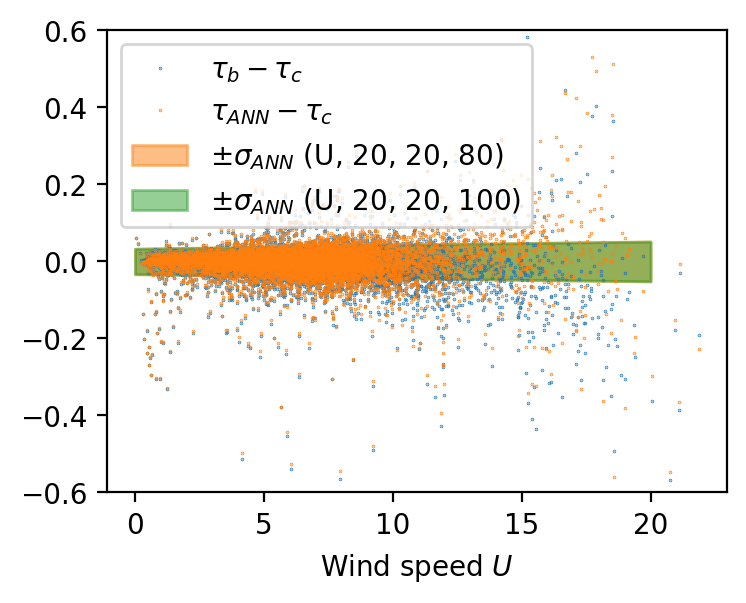

In [20]:
plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,0], vd.Bulk-vd.Y, '.', markersize=0.5, label=r'$\tau_b - \tau_c$')

# filename = model_dir + model_names[0] %10
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)

    plt.plot(vd.X[:,0], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=0.5, label=r'$\tau_{ANN} - \tau_c$')
    
    U = np.linspace(0,20,101).reshape(-1,1)
    Ta = np.ones([101,1]) * 20
    To = np.ones([101,1]) * 20
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,0], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C1', label=r'$\pm\sigma_{ANN}$ (U, 20, 20, 80)')

    U = np.linspace(0,20,101).reshape(-1,1)
    Ta = np.ones([101,1]) * 20
    To = np.ones([101,1]) * 20
    RH = np.ones([101,1]) * 100
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,0], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C2', label=r'$\pm\sigma_{ANN}$ (U, 20, 20, 100)')


plt.xlabel('Wind speed $U$')
plt.ylim([-0.6,0.6])
plt.legend()

(-0.6, 0.6)

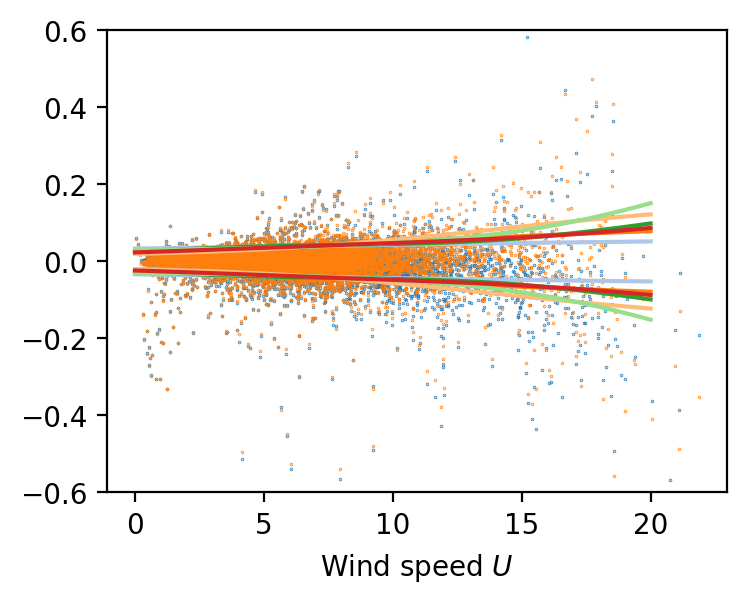

In [28]:
plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,0], vd.Bulk-vd.Y, '.', markersize=0.5, label=r'$\tau_b - \tau_c$')

filename = model_dir + 'Flux41_momentum_3layers_split%g.p' %i
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)  
    plt.plot(vd.X[:,0], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=0.5, label=r'$\tau_{ANN} - \tau_c$')


for i in (1,2,3,4,5,6):
    filename = model_dir + 'Flux41_momentum_3layers_split%g.p' %i
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file) 
        
        U = np.linspace(0,20,101).reshape(-1,1)
        Ta = np.ones([101,1]) * 20
        To = np.ones([101,1]) * 20
        RH = np.ones([101,1]) * 80
        X = np.hstack([U,To,Ta,RH]).astype('float32')
    
        std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
        plt.plot(X[:,0], std_pred.flatten(), c=plt.get_cmap('tab20')(i))
        plt.plot(X[:,0], -std_pred.flatten(), c=plt.get_cmap('tab20')(i))

plt.xlabel('Wind speed $U$')
plt.ylim([-0.6,0.6])
# plt.legend()

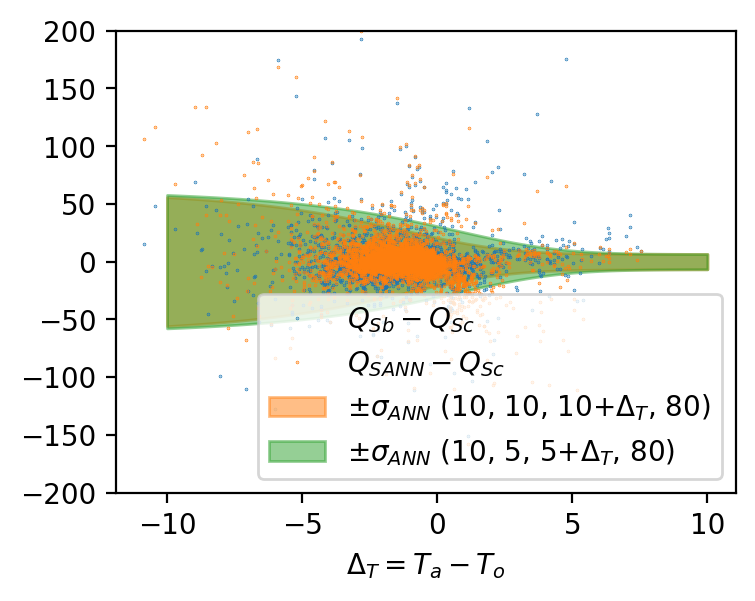

In [10]:
plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,2]-vd.X[:,1], vd.Bulk-vd.Y, '.', markersize=0.5, label=r'$Q_{Sb} - Q_{Sc}$')

# filename = model_dir + model_names[1] %10
filename = model_dir + 'Flux41_sensible_3layers_split%g.p' %2

with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)

    plt.plot(vd.X[:,2]-vd.X[:,1], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=0.5, label=r'$Q_{SANN} - Q_{Sc}$')
    
    U = np.ones([101,1]) * 10
    Ta = np.linspace(0,20,101).reshape(-1,1)
    To = np.ones([101,1]) * 10
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,2]-X[:,1], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C1', label=r'$\pm\sigma_{ANN}$ (10, 10, 10+$\Delta_T$, 80)')

    U = np.ones([101,1]) * 10
    Ta = np.linspace(-5,15,101).reshape(-1,1)
    To = np.ones([101,1]) * 5
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,2]-X[:,1], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C2', label=r'$\pm\sigma_{ANN}$ (10, 5, 5+$\Delta_T$, 80)')


plt.xlabel(r'$\Delta_T = T_a-T_o$')
plt.ylim([-200,200])
plt.legend()

(-200.0, 200.0)

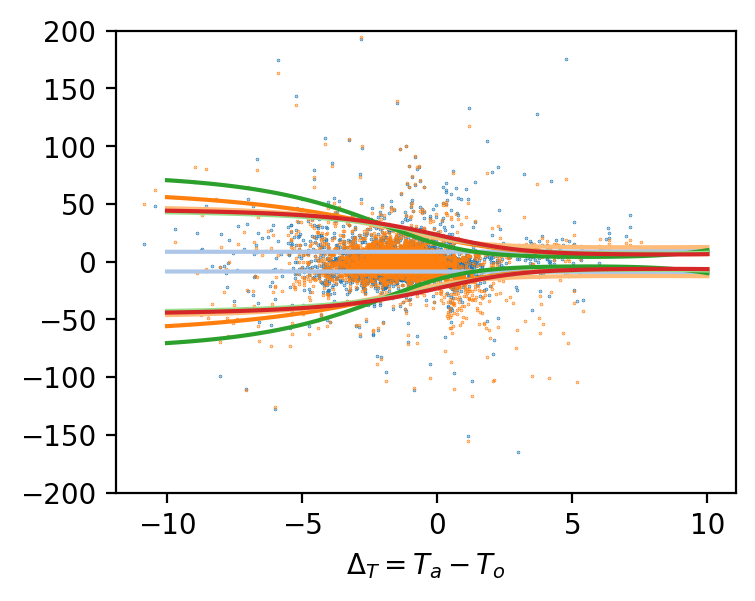

In [32]:
plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,2]-vd.X[:,1], vd.Bulk-vd.Y, '.', markersize=0.5, label=r'$Q_{Sb} - Q_{Sc}$')

filename = model_dir + 'Flux41_sensible_3layers_split%g.p' %i
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)  
    plt.plot(vd.X[:,2]-vd.X[:,1], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=0.5, label=r'$\tau_{ANN} - \tau_c$')


for i in (1,2,3,4,5,6):
    filename = model_dir + 'Flux41_sensible_3layers_split%g.p' %i
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file) 
        
        U = np.ones([101,1]) * 10
        Ta = np.linspace(0,20,101).reshape(-1,1)
        To = np.ones([101,1]) * 10
        RH = np.ones([101,1]) * 80
        X = np.hstack([U,To,Ta,RH]).astype('float32')
  
        std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
        plt.plot(X[:,2]-X[:,1], std_pred.flatten(), c=plt.get_cmap('tab20')(i))
        plt.plot(X[:,2]-X[:,1], -std_pred.flatten(), c=plt.get_cmap('tab20')(i))

plt.xlabel(r'$\Delta_T = T_a-T_o$')
plt.ylim([-200,200])
# plt.legend()

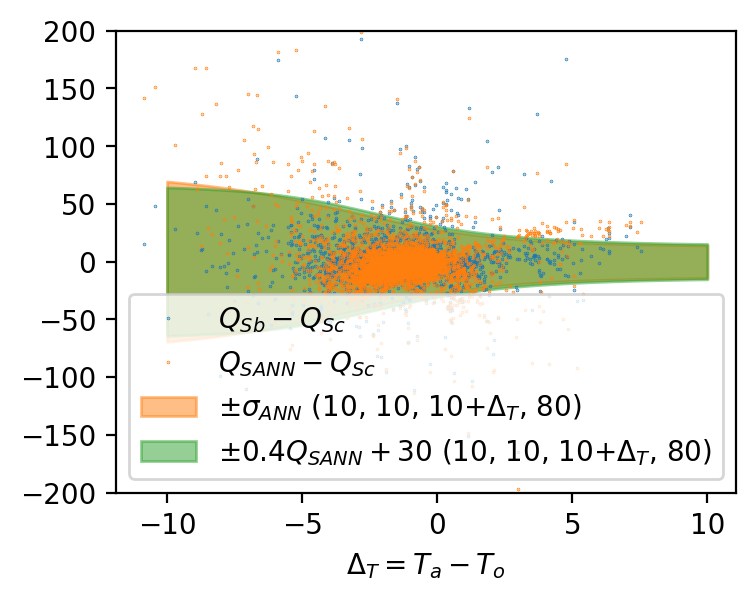

In [105]:
plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,2]-vd.X[:,1], vd.Bulk-vd.Y, '.', markersize=0.5, label=r'$Q_{Sb} - Q_{Sc}$')

filename = model_dir + model_names[1] %10
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)

    plt.plot(vd.X[:,2]-vd.X[:,1], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=0.5, label=r'$Q_{SANN} - Q_{Sc}$')
    
    U = np.ones([101,1]) * 10
    Ta = np.linspace(0,20,101).reshape(-1,1)
    To = np.ones([101,1]) * 10
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,2]-X[:,1], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C1', label=r'$\pm\sigma_{ANN}$ (10, 10, 10+$\Delta_T$, 80)')

    U = np.ones([101,1]) * 10
    Ta = np.linspace(0,20,101).reshape(-1,1)
    To = np.ones([101,1]) * 10
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = -model.pred_mean(torch.tensor(X)).detach().numpy()*0.4 + 30
    plt.fill_between(x=X[:,2]-X[:,1], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C2', label=r'$\pm 0.4Q_{SANN} + 30$ (10, 10, 10+$\Delta_T$, 80)')


plt.xlabel(r'$\Delta_T = T_a-T_o$')
plt.ylim([-200,200])
plt.legend()

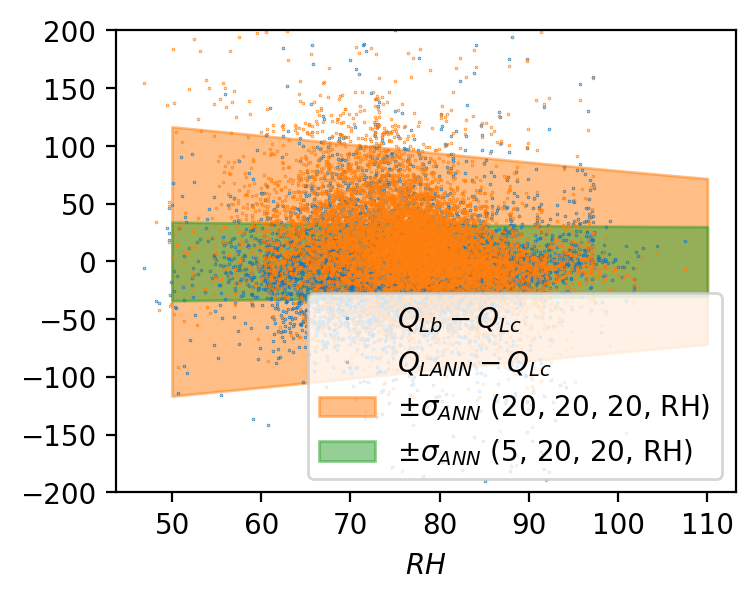

In [91]:
plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

plt.plot(vd.X[:,3], vd.Bulk-vd.Y, '.', markersize=0.5, label=r'$Q_{Lb} - Q_{Lc}$')

filename = model_dir + model_names[2] %8
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)

    plt.plot(vd.X[:,3], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=0.5, label=r'$Q_{LANN} - Q_{Lc}$')
    
    U = np.ones([101,1]) * 20
    Ta = np.ones([101,1]) * 20
    To = np.ones([101,1]) * 20
    RH = np.linspace(50,110,101).reshape(-1,1)
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,3], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C1', label=r'$\pm\sigma_{ANN}$ (20, 20, 20, RH)')

    U = np.ones([101,1]) * 20
    Ta = np.ones([101,1]) * 20
    To = np.ones([101,1]) * 20
    RH = np.linspace(50,110,101).reshape(-1,1)
    X = np.hstack([U,To,Ta,RH]).astype('float32')

    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,3], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C2', label=r'$\pm\sigma_{ANN}$ (20, 20, 20, RH)')


plt.xlabel(r'$RH$')
plt.ylim([-200,200])
plt.legend()